In [1]:
# https://github.com/nicola-decao/MolGAN/blob/master/utils/sparse_molecular_dataset.py

import pickle
import numpy as np

from rdkit import Chem
from datetime import datetime

In [2]:
class SparseMolecularDataset():

    def load(self, filename, subset=1):

        with open(filename, 'rb') as f:
            __dict__.update(pickle.load(f))

        train_idx = np.random.choice(self.train_idx, int(len(self.train_idx) * subset), replace=False)
        self.validation_idx = np.random.choice(self.validation_idx, int(len(self.validation_idx) * subset),
                                               replace=False)
        self.test_idx = np.random.choice(self.test_idx, int(len(self.test_idx) * subset), replace=False)

        self.train_count = len(self.train_idx)
        self.validation_count = len(self.validation_idx)
        self.test_count = len(self.test_idx)

        self.__len = self.train_count + self.validation_count + self.test_count

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def generate(self, filename, add_h=False, filters=lambda x: True, size=None, validation=0.1, test=0.1):
        self.log('Extracting {}..'.format(filename))

        if filename.endswith('.sdf'):
            self.data = list(filter(lambda x: x is not None, Chem.SDMolSupplier(filename)))
        elif filename.endswith('.smi'):
            self.data = [Chem.MolFromSmiles(line) for line in open(filename, 'r').readlines()]

        self.data = list(map(Chem.AddHs, self.data)) if add_h else self.data
        self.data = list(filter(filters, self.data))
        self.data = self.data[:size]

        self.log('Extracted {} out of {} molecules {}adding Hydrogen!'.format(len(self.data),
                                                                              len(Chem.SDMolSupplier(filename)),
                                                                              '' if add_h else 'not '))

        self._generate_encoders_decoders()
        self._generate_AX()

        self.data = np.array(self.data)
        self.smiles = np.array(self.smiles)
        self.data_S = np.stack(self.data_S)
        self.data_A = np.stack(self.data_A)
        self.data_X = np.stack(self.data_X)
        self.data_D = np.stack(self.data_D)
        self.data_F = np.stack(self.data_F)
        self.data_Le = np.stack(self.data_Le)
        self.data_Lv = np.stack(self.data_Lv)

        self.vertexes = self.data_F.shape[-2]
        self.features = self.data_F.shape[-1]

        self._generate_train_validation_test(validation, test)

    def _generate_encoders_decoders(self):
        self.log('Creating atoms encoder and decoder..')
        atom_labels = sorted(set([atom.GetAtomicNum() for mol in self.data for atom in mol.GetAtoms()] + [0]))
        self.atom_encoder_m = {l: i for i, l in enumerate(atom_labels)}
        self.atom_decoder_m = {i: l for i, l in enumerate(atom_labels)}
        self.atom_num_types = len(atom_labels)
        self.log('Created atoms encoder and decoder with {} atom types and 1 PAD symbol!'.format(
            self.atom_num_types - 1))

        self.log('Creating bonds encoder and decoder..')
        bond_labels = [Chem.rdchem.BondType.ZERO] + list(sorted(set(bond.GetBondType()
                                                                    for mol in self.data
                                                                    for bond in mol.GetBonds())))

        self.bond_encoder_m = {l: i for i, l in enumerate(bond_labels)}
        self.bond_decoder_m = {i: l for i, l in enumerate(bond_labels)}
        self.bond_num_types = len(bond_labels)
        self.log('Created bonds encoder and decoder with {} bond types and 1 PAD symbol!'.format(
            self.bond_num_types - 1))

        self.log('Creating SMILES encoder and decoder..')
        smiles_labels = ['E'] + list(set(c for mol in self.data for c in Chem.MolToSmiles(mol)))
        self.smiles_encoder_m = {l: i for i, l in enumerate(smiles_labels)}
        self.smiles_decoder_m = {i: l for i, l in enumerate(smiles_labels)}
        self.smiles_num_types = len(smiles_labels)
        self.log('Created SMILES encoder and decoder with {} types and 1 PAD symbol!'.format(
            self.smiles_num_types - 1))

    def _generate_AX(self):
        self.log('Creating features and adjacency matrices..')

        data = []
        smiles = []
        data_S = []
        data_A = []
        data_X = []
        data_D = []
        data_F = []
        data_Le = []
        data_Lv = []

        max_length = max(mol.GetNumAtoms() for mol in self.data)
        max_length_s = max(len(Chem.MolToSmiles(mol)) for mol in self.data)

        for i, mol in enumerate(self.data):
            A = self._genA(mol, connected=True, max_length=max_length)
            D = np.count_nonzero(A, -1)
            if A is not None:
                data.append(mol)
                smiles.append(Chem.MolToSmiles(mol))
                data_S.append(self._genS(mol, max_length=max_length_s))
                data_A.append(A)
                data_X.append(self._genX(mol, max_length=max_length))
                data_D.append(D)
                data_F.append(self._genF(mol, max_length=max_length))

                L = D - A
                Le, Lv = np.linalg.eigh(L)

                data_Le.append(Le)
                data_Lv.append(Lv)

        self.log(date=False)
        self.log('Created {} features and adjacency matrices  out of {} molecules!'.format(len(data),
                                                                                           len(self.data)))

        self.data = data
        self.smiles = smiles
        self.data_S = data_S
        self.data_A = data_A
        self.data_X = data_X
        self.data_D = data_D
        self.data_F = data_F
        self.data_Le = data_Le
        self.data_Lv = data_Lv
        self.__len = len(self.data)

    def _genA(self, mol, connected=True, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        A = np.zeros(shape=(max_length, max_length), dtype=np.int32)

        begin, end = [b.GetBeginAtomIdx() for b in mol.GetBonds()], [b.GetEndAtomIdx() for b in mol.GetBonds()]
        bond_type = [self.bond_encoder_m[b.GetBondType()] for b in mol.GetBonds()]

        A[begin, end] = bond_type
        A[end, begin] = bond_type

        degree = np.sum(A[:mol.GetNumAtoms(), :mol.GetNumAtoms()], axis=-1)

        return A if connected and (degree > 0).all() else None

    def _genX(self, mol, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        return np.array([self.atom_encoder_m[atom.GetAtomicNum()] for atom in mol.GetAtoms()] + [0] * (
                    max_length - mol.GetNumAtoms()), dtype=np.int32)

    def _genS(self, mol, max_length=None):

        max_length = max_length if max_length is not None else len(Chem.MolToSmiles(mol))

        return np.array([self.smiles_encoder_m[c] for c in Chem.MolToSmiles(mol)] + [self.smiles_encoder_m['E']] * (
                    max_length - len(Chem.MolToSmiles(mol))), dtype=np.int32)

    def _genF(self, mol, max_length=None):

        max_length = max_length if max_length is not None else mol.GetNumAtoms()

        features = np.array([[*[a.GetDegree() == i for i in range(5)],
                              *[a.GetExplicitValence() == i for i in range(9)],
                              *[int(a.GetHybridization()) == i for i in range(1, 7)],
                              *[a.GetImplicitValence() == i for i in range(9)],
                              a.GetIsAromatic(),
                              a.GetNoImplicit(),
                              *[a.GetNumExplicitHs() == i for i in range(5)],
                              *[a.GetNumImplicitHs() == i for i in range(5)],
                              *[a.GetNumRadicalElectrons() == i for i in range(5)],
                              a.IsInRing(),
                              *[a.IsInRingSize(i) for i in range(2, 9)]] for a in mol.GetAtoms()], dtype=np.int32)

        return np.vstack((features, np.zeros((max_length - features.shape[0], features.shape[1]))))

    def matrices2mol(self, node_labels, edge_labels, strict=False):
        mol = Chem.RWMol()

        for node_label in node_labels:
            mol.AddAtom(Chem.Atom(self.atom_decoder_m[node_label]))

        for start, end in zip(*np.nonzero(edge_labels)):
            if start > end:
                mol.AddBond(int(start), int(end), self.bond_decoder_m[edge_labels[start, end]])

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol

    def seq2mol(self, seq, strict=False):
        mol = Chem.MolFromSmiles(''.join([self.smiles_decoder_m[e] for e in seq if e != 0]))

        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None

        return mol

    def _generate_train_validation_test(self, validation, test):

        self.log('Creating train, validation and test sets..')

        validation = int(validation * len(self))
        test = int(test * len(self))
        train = len(self) - validation - test

        self.all_idx = np.random.permutation(len(self))
        self.train_idx = self.all_idx[0:train]
        self.validation_idx = self.all_idx[train:train + validation]
        self.test_idx = self.all_idx[train + validation:]

        self.train_counter = 0
        self.validation_counter = 0
        self.test_counter = 0

        self.train_count = train
        self.validation_count = validation
        self.test_count = test

        self.log('Created train ({} items), validation ({} items) and test ({} items) sets!'.format(
            train, validation, test))

    def _next_batch(self, counter, count, idx, batch_size):
        if batch_size is not None:
            if counter + batch_size >= count:
                counter = 0
                np.random.shuffle(idx)

            output = [obj[idx[counter:counter + batch_size]]
                      for obj in (self.data, self.smiles, self.data_S, self.data_A, self.data_X,
                                  self.data_D, self.data_F, self.data_Le, self.data_Lv)]

            counter += batch_size
        else:
            output = [obj[idx] for obj in (self.data, self.smiles, self.data_S, self.data_A, self.data_X,
                                           self.data_D, self.data_F, self.data_Le, self.data_Lv)]

        return [counter] + output

    def next_train_batch(self, batch_size=None):
        out = self._next_batch(counter=self.train_counter, count=self.train_count,
                               idx=self.train_idx, batch_size=batch_size)
        self.train_counter = out[0]

        return out[1:]

    def next_validation_batch(self, batch_size=None):
        out = self._next_batch(counter=self.validation_counter, count=self.validation_count,
                               idx=self.validation_idx, batch_size=batch_size)
        self.validation_counter = out[0]

        return out[1:]

    def next_test_batch(self, batch_size=None):
        out = self._next_batch(counter=self.test_counter, count=self.test_count,
                               idx=self.test_idx, batch_size=batch_size)
        self.test_counter = out[0]

        return out[1:]

    @staticmethod
    def log(msg='', date=True):
        print(str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) + ' ' + str(msg) if date else str(msg))

    def __len__(self):
        return self.__len

In [3]:
# QM9 dataset
data = SparseMolecularDataset()


In [7]:
data.generate('../data/qm9_5k.smi', filters=lambda x: x.GetNumAtoms() <= 9)

2023-03-18 20:30:11 Extracting ../data/qm9_5k.smi..
2023-03-18 20:30:11 Extracted 4989 out of 1 molecules not adding Hydrogen!
2023-03-18 20:30:11 Creating atoms encoder and decoder..
2023-03-18 20:30:11 Created atoms encoder and decoder with 4 atom types and 1 PAD symbol!
2023-03-18 20:30:11 Creating bonds encoder and decoder..
2023-03-18 20:30:12 Created bonds encoder and decoder with 4 bond types and 1 PAD symbol!
2023-03-18 20:30:12 Creating SMILES encoder and decoder..
2023-03-18 20:30:12 Created SMILES encoder and decoder with 21 types and 1 PAD symbol!
2023-03-18 20:30:12 Creating features and adjacency matrices..

2023-03-18 20:30:17 Created 4989 features and adjacency matrices  out of 4989 molecules!
2023-03-18 20:30:17 Creating train, validation and test sets..
2023-03-18 20:30:17 Created train (3993 items), validation (498 items) and test (498 items) sets!


In [23]:
data.__dict__.keys()

dict_keys(['data', 'atom_encoder_m', 'atom_decoder_m', 'atom_num_types', 'bond_encoder_m', 'bond_decoder_m', 'bond_num_types', 'smiles_encoder_m', 'smiles_decoder_m', 'smiles_num_types', 'smiles', 'data_S', 'data_A', 'data_X', 'data_D', 'data_F', 'data_Le', 'data_Lv', '_SparseMolecularDataset__len', 'vertexes', 'features', 'all_idx', 'train_idx', 'validation_idx', 'test_idx', 'train_counter', 'validation_counter', 'test_counter', 'train_count', 'validation_count', 'test_count'])

In [45]:
data.validation_counter

0

smiles = C1OC2C3OC4C3CC142


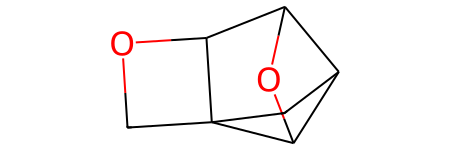

In [48]:
n = 11
print(f'smiles = {data.smiles[n]}')
data.data[n]

In [22]:
len(data.smiles_encoder_m)

22

In [20]:
data.bond_encoder_m

{rdkit.Chem.rdchem.BondType.ZERO: 0,
 rdkit.Chem.rdchem.BondType.SINGLE: 1,
 rdkit.Chem.rdchem.BondType.DOUBLE: 2,
 rdkit.Chem.rdchem.BondType.TRIPLE: 3,
 rdkit.Chem.rdchem.BondType.AROMATIC: 4}

In [19]:
data.atom_decoder_m

{0: 0, 1: 6, 2: 7, 3: 8, 4: 9}

In [18]:
data.atom_encoder_m

{0: 0, 6: 1, 7: 2, 8: 3, 9: 4}